# Preliminary Pulsar data analysis

In [1]:
library(tidyverse)
library(ggplot2)
library(dplyr) 
library(tidymodels)
install.packages("corrplot")
library(corrplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1. import the data, tidy the data set, show summary statistics 

In [2]:
# import data
#temp  <- tempfile()
#download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip",temp)
pulsar <- read.csv("https://raw.githubusercontent.com/RowanYuwenLUO/dsci100_2022w1_group168/main/HTRU_2.csv",
                   header = FALSE, 
                   col.names = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness",
                                 "Class"))

In [3]:
# dimension of the data set
dim(pulsar) 

[1] 17898     9

- 17898 observations (rows)
- 9 variables (columns)

In [4]:
head(pulsar)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
2,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
3,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
4,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
5,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
6,93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [5]:
# summary statistics for all 8 predictors
summary_table <- data.frame(cbind(summary(pulsar$integr.mean), summary(pulsar$integr.std),
                                  summary(pulsar$integr.kurtosis), summary(pulsar$integr.skewness),
                                  summary(pulsar$DMSNR.mean), summary(pulsar$DMSNR.std), 
                                  summary(pulsar$DMSNR.kurtosis), summary(pulsar$DMSNR.skewness))) 
colnames(summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,5.8125,24.77204,-1.87601118,-1.7918860,0.2132107,7.370432,-3.139270,-1.976976
1st Qu.,100.9297,42.37602,0.02709812,-0.1885717,1.9230769,14.437332,5.781506,34.960504
Median,115.0781,46.94748,0.22324002,0.1987104,2.8018395,18.461316,8.433515,83.064556
Mean,111.0800,46.54953,0.47785726,1.7702790,12.6143997,26.326515,8.303556,104.857709
3rd Qu.,127.0859,51.02320,0.47332518,0.9277831,5.4642559,28.428104,10.702959,139.309330
Max.,192.6172,98.77891,8.06952205,68.1016217,223.3921405,110.642211,34.539844,1191.000837


In [6]:
# check the missing data
sum(is.na(pulsar))

[1] 0

- no missing data here

In [7]:
# show number of observations in each class
count_data <- pulsar %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar))
count_data 

Class,n,freq
<int>,<int>,<dbl>
0,16259,0.90842552
1,1639,0.09157448


- `0 is the negative examples`
- `1 is the positive examples`
- majority of the data (around 90%) are in class 0

## 2. split the data into training and testing sets

In [8]:
set.seed(123)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

In [9]:
# dimension of the training data set 
dim(pulsar_train) 

[1] 13423     9

In [27]:
# number of observations in each class
count_train <- pulsar_train %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar_train))
count_train
cbind(count_data, count_train)

Class,n,freq
<int>,<int>,<dbl>
0,12170,0.90665276
1,1253,0.09334724


Class,n,freq,Class,n,freq
<int>,<int>,<dbl>,<int>,<int>,<dbl>
0,16259,0.90842552,0,12170,0.90665276
1,1639,0.09157448,1,1253,0.09334724


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



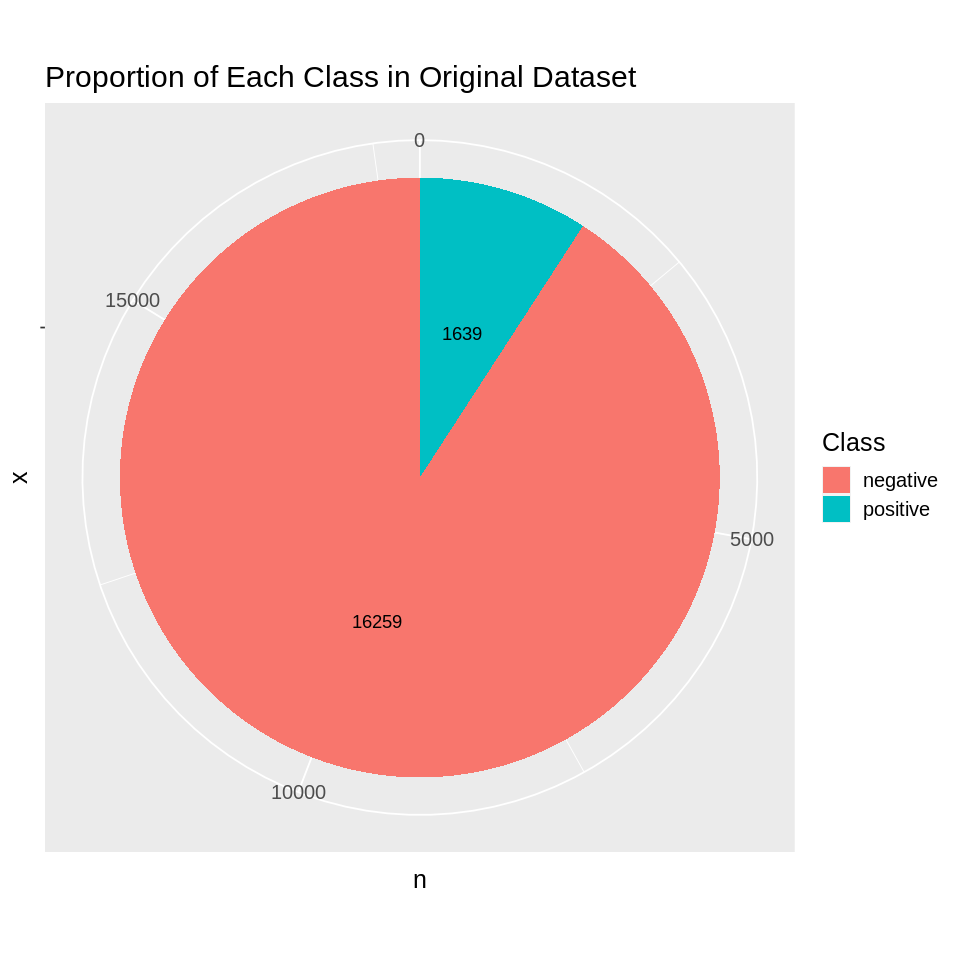

In [38]:
options(repr.plot.width = 8, repr.plot.height = 8) 

ggplot(count_data, aes(x = "", y = n, fill = as.factor(Class))) +
  geom_bar(stat = "identity") + 
  geom_text(aes(label = n), position = position_stack(vjust = 0.5)) + 
  coord_polar(theta = "y", start = 0) + 
  scale_fill_brewer(palette = 'Pastel1') + 
  scale_fill_discrete(labels = c("negative", "positive")) + 
  ggtitle("Proportion of Each Class in Original Dataset") + 
  labs(fill = "Class") + 
  theme(text = element_text(size=15)) 

- training data set show the almost same proportion as the original dataset

## 3. Sample down the `0 (negative) class` in the training set: to deal with the imbalancing probelm.
### - let the number of data belongs to class 0 = the number of data belongs to class 1
### - so that proportion for the two classes are the same, equals to 0.5

In [13]:
set.seed(123)
train_c1 <- filter(pulsar_train, Class == 1)
train_c0 <- filter(pulsar_train, Class == 0)

sample_down_train <- pulsar_train %>% 
  filter(Class ==0) %>%
  sample_n(nrow(train_c1)) %>%
  rbind(train_c1)

In [14]:
# dimension for the training data after sampling down
dim(sample_down_train)

[1] 2506    9

- 2506 observations
- 9 variables

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



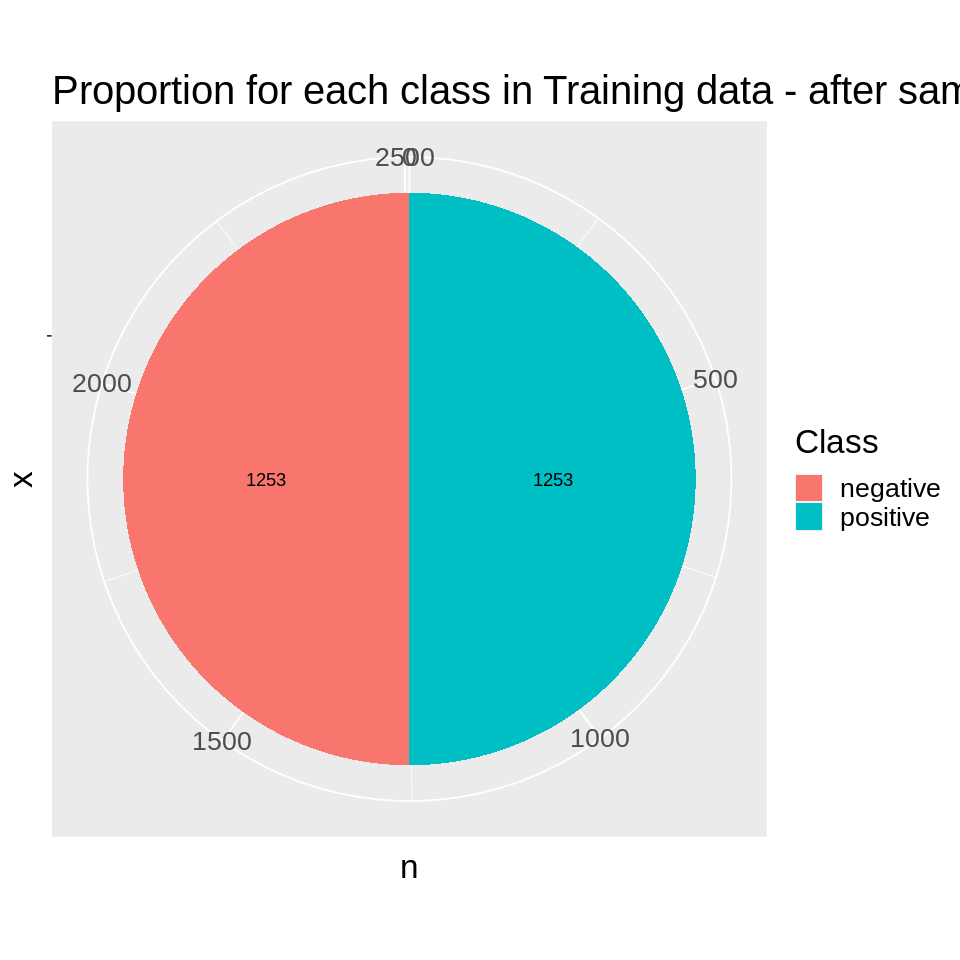

In [39]:
options(repr.plot.width = 8, repr.plot.height = 8) 

sample_down_train %>% 
  group_by(Class) %>% 
  summarise(n=n()) %>%
  ggplot(aes(x = "", y = n, fill = as.factor(Class))) +
  geom_bar(stat = "identity") + 
  geom_text(aes(label = n), position = position_stack(vjust = 0.5)) + 
  coord_polar(theta = "y", start = 0) + 
  scale_fill_brewer(palette = 'Pastel1') + 
  scale_fill_discrete(labels = c("negative", "positive")) + 
  ggtitle("Proportion for each class in Training data - after sample down") + 
  labs(fill = "Class") + 
  theme(text = element_text(size=20))

### now use the training set after sampling down to do the analysis !

In [16]:
# calculate the means of the predictor variables
predictors_mean <- sample_down_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(predictors_mean) <- "mean"
predictors_mean

,mean
,<dbl>
integr.mean,86.256958
integr.std,42.861345
integr.kurtosis,1.700721
integr.skewness,8.177292
DMSNR.mean,29.887667
DMSNR.std,40.028187
DMSNR.kurtosis,5.824315
DMSNR.skewness,67.323829


#### large differences between the mean of these predictors:
the largest one is about 86, while the smallest one is only 1.7


## 4. Scale the training set after sampling down

In [17]:
all_predictors_name <- colnames(sample_down_train[, 1:8])

scaled_train <- sample_down_train %>% 
  mutate_at(all_predictors_name, ~(scale(.) %>% as.vector))

In [18]:
train_summary_table <- data.frame(cbind(summary(scaled_train$integr.mean), summary(scaled_train$integr.std),
                                  summary(scaled_train$integr.kurtosis), summary(scaled_train$integr.skewness),
                                  summary(scaled_train$DMSNR.mean), summary(scaled_train$DMSNR.std), 
                                  summary(scaled_train$DMSNR.kurtosis), summary(scaled_train$DMSNR.skewness))) 
colnames(train_summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
train_summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,-2.063690e+00,-2.167562e+00,-1.713450e+00,-7.536754e-01,-6.980701e-01,-1.310994e+00,-1.723480e+00,-6.851254e-01
1st Qu.,-8.460459e-01,-8.084394e-01,-7.530860e-01,-6.354165e-01,-6.467820e-01,-9.281084e-01,-8.585520e-01,-6.502978e-01
Median,2.374179e-01,4.664097e-02,-5.150877e-01,-5.389346e-01,-5.436098e-01,-3.045725e-01,-1.336230e-01,-3.934826e-01
Mean,1.698600e-16,3.169741e-16,1.794415e-17,-3.234156e-17,-1.430887e-17,-1.394447e-16,6.247955e-17,-9.230731e-18
3rd Qu.,8.099643e-01,7.350632e-01,6.425342e-01,2.861652e-01,2.393543e-01,9.147824e-01,6.931118e-01,3.099548e-01
Max.,2.539729e+00,4.905129e+00,3.173435e+00,4.711405e+00,4.163813e+00,2.722087e+00,5.372250e+00,9.950703e+00


In [19]:
scaled_predictors_mean <- scaled_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(scaled_predictors_mean) <- "mean"
scaled_predictors_mean

,mean
,<dbl>
integr.mean,1.686572e-16
integr.std,3.168992e-16
integr.kurtosis,1.484137e-17
integr.skewness,-3.649426e-17
DMSNR.mean,-1.664808e-17
DMSNR.std,-1.331459e-16
DMSNR.kurtosis,5.974620e-17
DMSNR.skewness,-7.091184e-18


#### After scaling the predictos in thetraining set, every predictor has mean around 0.

In [20]:
head(scaled_train)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.9530132,1.8106637,-0.8168831,-0.7010886,-0.6561685,-1.0755796,0.89087155,0.7126506,0
2,1.0886967,3.6593985,-0.8675785,-0.7536754,1.5101584,1.5944108,-1.15877415,-0.6803251,0
3,1.3450323,0.5883488,-1.0096455,-0.6209852,-0.6637171,-1.0960985,1.17488947,1.0446210,0
4,0.7439764,1.0821099,-0.6363887,-0.6296116,-0.3042426,0.5808810,-0.59015834,-0.5998106,0
5,0.8339644,-0.0828916,-0.6085113,-0.5989493,-0.5693893,-0.3795561,-0.00139643,-0.3265444,0
6,-0.1064005,-0.6559463,-0.4430658,-0.4385813,-0.6034269,-0.5059058,0.22646530,-0.1780283,0


## 5. visualize the training set

In [21]:
pivot_train <- scaled_train %>%
  pivot_longer(cols = integr.mean:DMSNR.skewness,
               names_to = "predictor", 
               values_to = "value")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



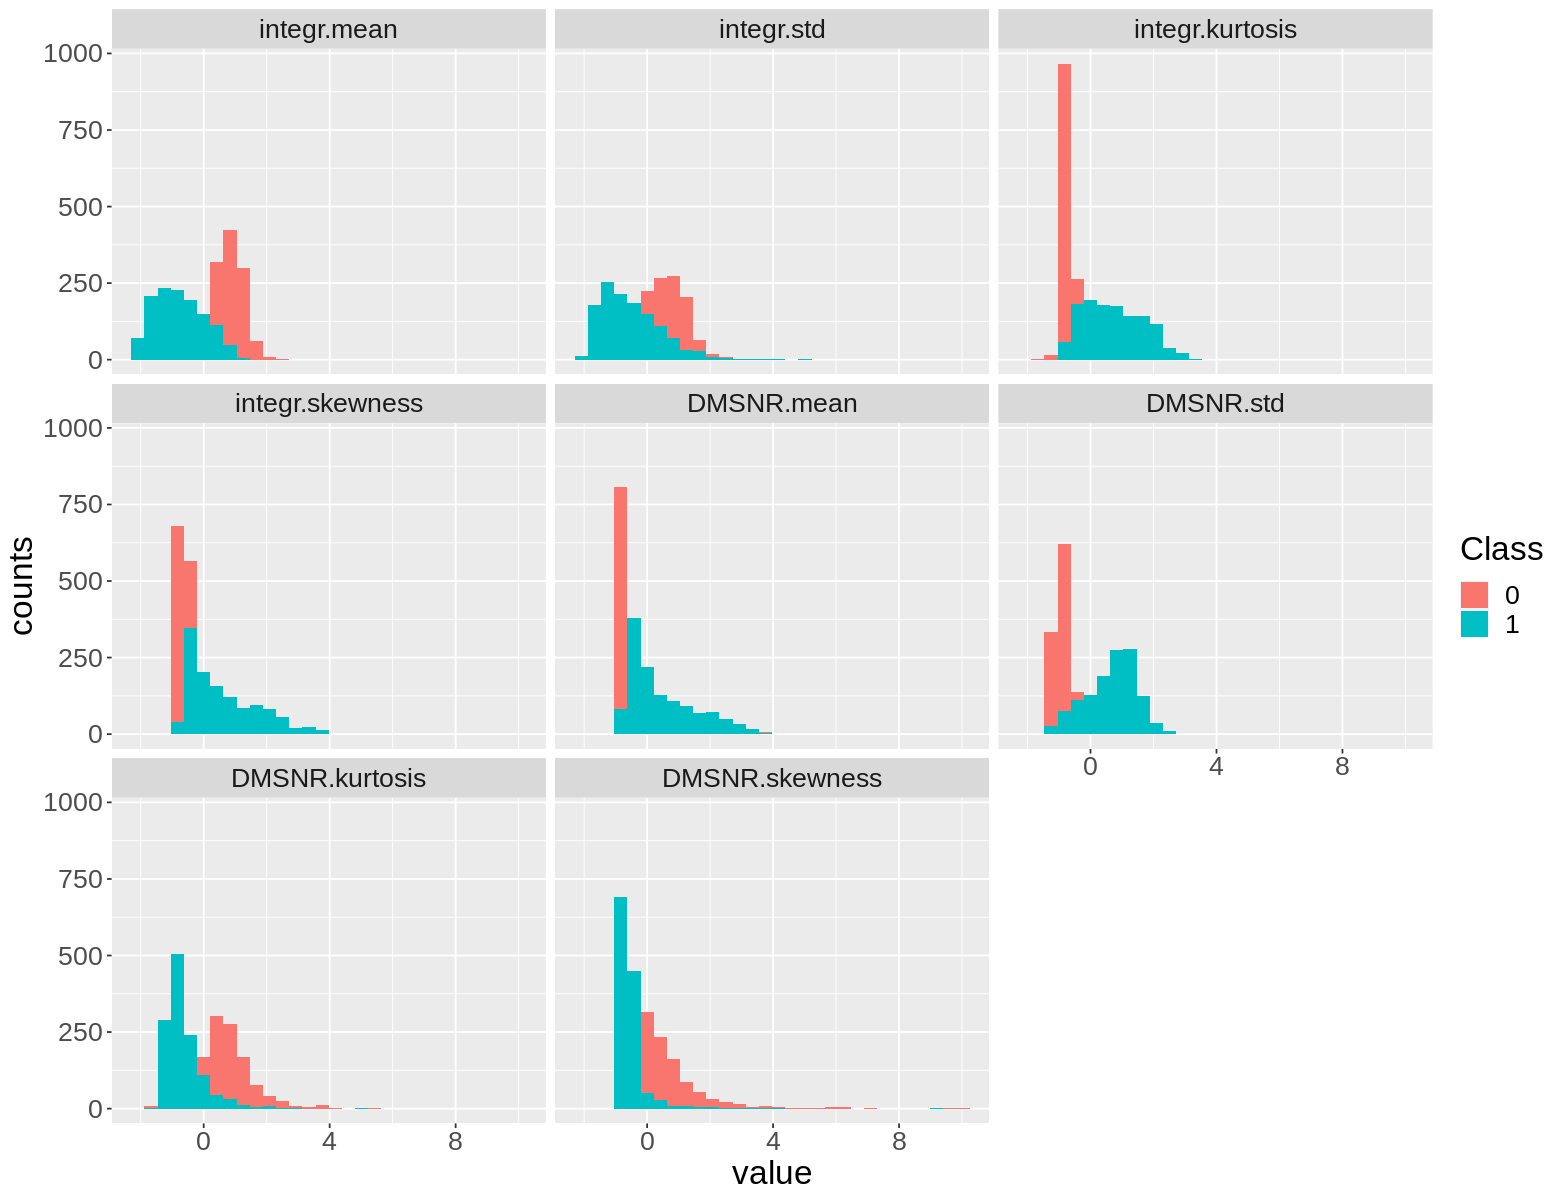

In [31]:
# histogram for all 8 variables
options(repr.plot.width = 13, repr.plot.height = 10) 

pivot_train %>% 
  ggplot(aes(x = value, fill = as.factor(Class))) + 
  geom_histogram(position = "identity") + 
  facet_wrap(~ factor(predictor, 
                      levels = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness"))) +
  xlab("value") + 
  ylab("counts") + 
  labs(fill = "Class") +
  theme(text = element_text(size=20)) 

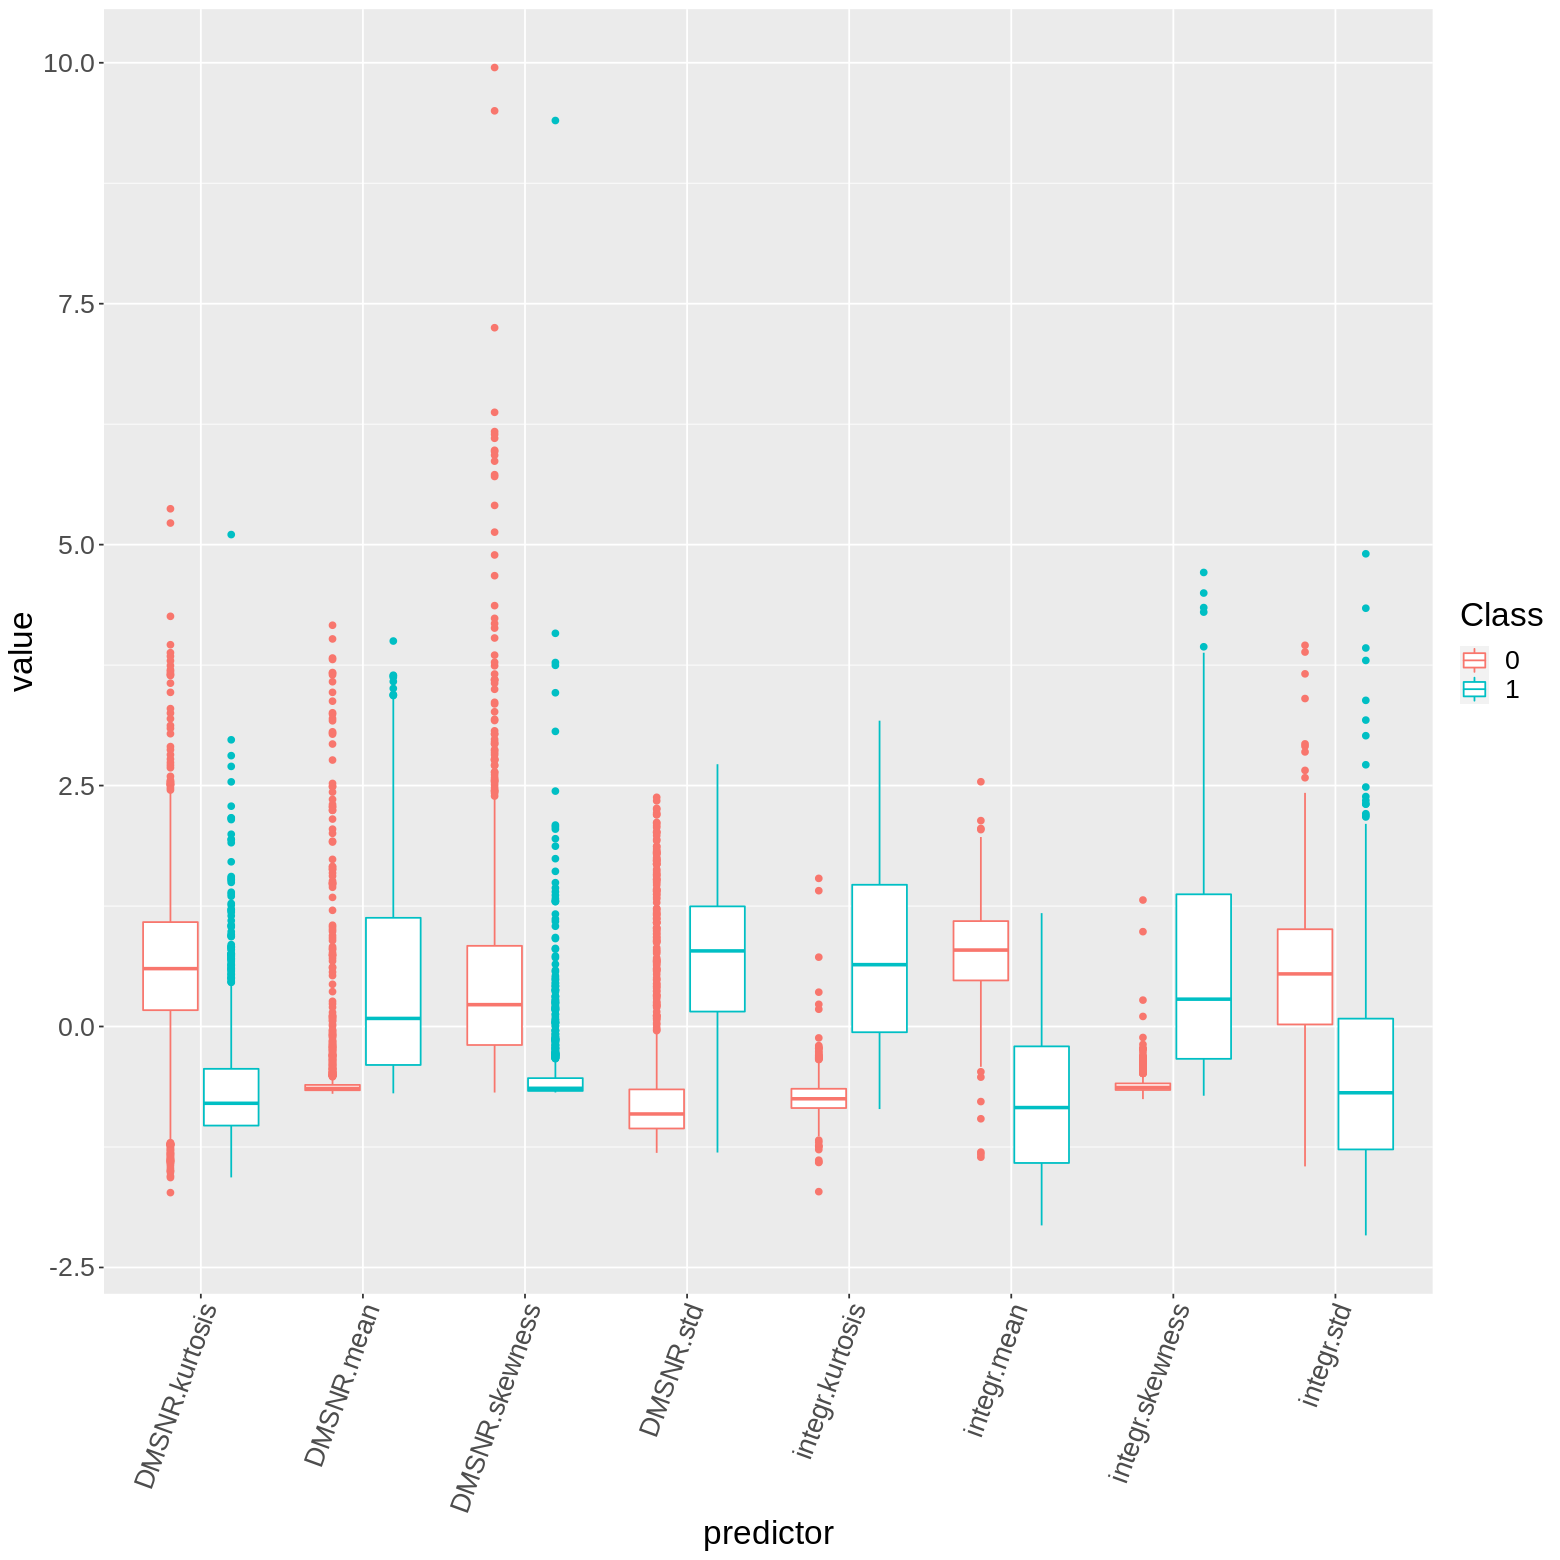

In [35]:
# boxplot
options(repr.plot.width = 13, repr.plot.height = 13) 

ggplot(pivot_train, aes(x=predictor, y=value, color = as.factor(Class))) + 
  geom_boxplot() + 
  labs(color = "Class") +
  theme(axis.text.x = element_text(angle = 70, hjust = 1),
        text = element_text(size=20)) 

##### Both histogram and Boxplot are used to explore the relationship between continuous variables and a categorical variable.
##### show the differences between the each category class
- `integr.mean`, `integr.std`, `DMSNR.kurtosis`, `DMSNR.skewness` predictors has larger mean in Class 0;
- `integr.kurtosis`, `integr.skewness`, `DMSNR.std`, `DMSNR.mean` predictors has larger mean in Class 1;

-  data from `DMSNR.skewness` in Class 0 has the most spread distribution;
-  all predictors have a lot of outliers shown from the boxplot;
-  almost all predictors in both Classes show skewed to right distribution, except the `DMSNR.std` variable.

## 6. Choose predictors

#### In the dataset, the Categorical variable Class `Class` has been tranformed into a `dummy variable`: has values equal to either 0 or 1.

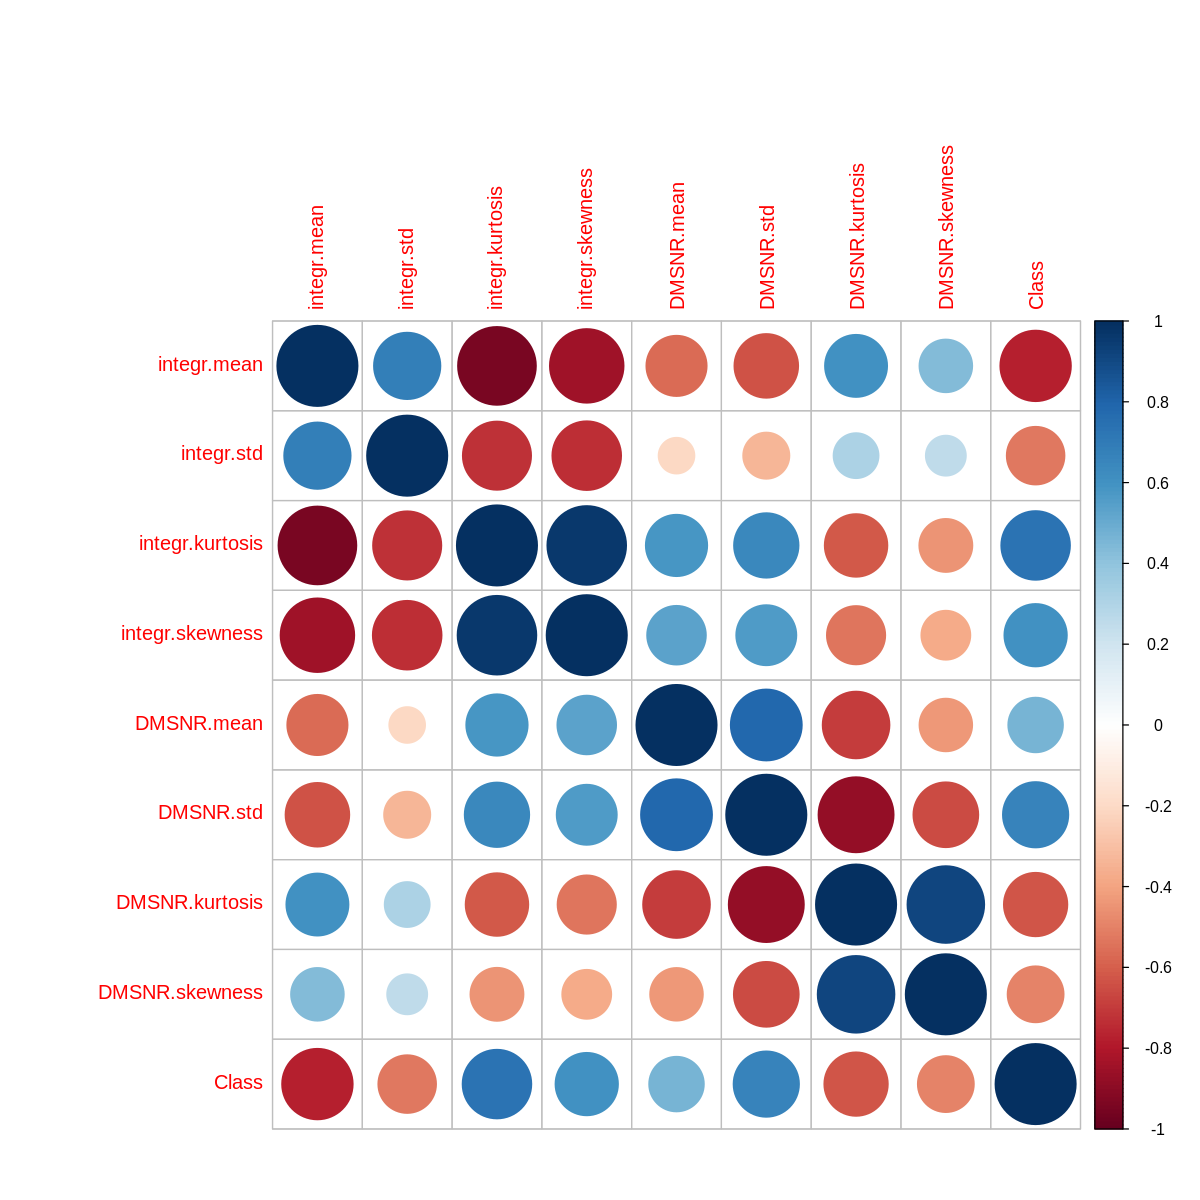

In [24]:
options(repr.plot.width = 10, repr.plot.height = 10) 
corrplot(cor(scaled_train))

In [2]:
plot(cor(scaled_train))

ERROR: Error in is.data.frame(x): object 'scaled_train' not found


In [ ]:
corr.mat <- cor(scaled_train)
corr.mat
corr.mat[ , ncol(corr.mat), drop = FALSE] 

##### By looking at the last column of the correlation matrix, 
##### find `integr.mean`, `integr.kurtosis` are the most correlated predictors to `Class`, 
##### the absolute value of their correlation with `Class` are the largest;
##### and then are the `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` predictors.

### Thus, we will use the 5 predictors to do the classification analysis with `k-nn` method
`integr.mean`, `integr.kurtosis`, `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` 